In [1]:
import pandas as pd

/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Create a tabular data structure
X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'], 
                  'boolean':['yes', 'no', None, 'no', 'no', 'yes'], 
                  'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'], 
                  'quantitative_column':[1, 11, -.5, 10, None, 20]})
X

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [3]:
X.isnull().sum()

boolean                1
city                   1
ordinal_column         0
quantitative_column    1
dtype: int64

In [4]:
# Let's impute some values, imputer has a most_frequent option, but it only works if categories are integers
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
X['city'].value_counts().index[0]  
# Most common category

'tokyo'

In [6]:
X['city'].fillna(X['city'].value_counts().index[0])  
# Fill empty slots with most common category

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

## Custom category imputer

1. Pipelines allow us to sequentially apply a list of transforms and a final estimator
2. Intermediate steps of the pipeline must be transforms, meaning they must implement <b>fit</b> and <b>transform</b> methods
3. The final estimator only needs to implement <b>fit</b>

In [7]:
from sklearn.base import TransformerMixin

In [8]:
class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    
    def fit(self, *_):
        return self

In [9]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])

In [10]:
cci.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


## Custom quantitative imputer

In [11]:
# Let's make an imputer that can apply a strategy to select columns by name
class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
        
    def transform(self, df):
        X = df.copy()
        impute = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    
    def fit(self, *_):
        return self

In [12]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean')

cqi.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


In [13]:
# Setup Pipeline() so that we can transform our dataset in one go 

In [14]:
imputer = Pipeline([('quant', cqi), ('category', cci)])

imputer.fit_transform(X)  # ready for action

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


## Custom dummifier for nominal level

To transform our categorical data into dummy variables:
1. Utilize pandas to automatically find the categorical variables and dummy code them
2. Create our own custom transformer using dummy variables to work in a pipeline

<b>Dummy variables</b> take the value zero or one to indicate the absence or presence of a category. They are proxy variables, or numerical stand-ins, for quantitative data. It's important to be aware of and avoid the <b>dummy variable trap</b>. The dummy variable trap is when you have independent variables that are multicollinear, or highly correlated. Simply put, these variables can be predicted from each other. 

In [15]:
# Will automatically find categorical variables
pd.get_dummies(X, prefix_sep='__')  
# The seperator between the prefix (column name) and cell value

,quantitative_column,boolean__no,boolean__yes,city__london,city__san francisco,city__seattle,city__tokyo,ordinal_column__dislike,ordinal_column__like,ordinal_column__somewhat like
0,1.0,0,1,0,0,0,1,0,0,1
1,11.0,1,0,0,0,0,0,0,1,0
2,-0.5,0,0,1,0,0,0,0,0,1
3,10.0,1,0,0,0,1,0,0,1,0
4,NaN,1,0,0,1,0,0,0,0,1
5,20.0,0,1,0,0,0,1,1,0,0


In [16]:
# For ordinal columns, we don't want to dummify
pd.get_dummies(X,
               # Which columns to dummify
               columns = ['city', 'boolean'],
               # The seperator between the prefix (column name) and cell value
               prefix_sep='__')

,ordinal_column,quantitative_column,city__london,city__san francisco,city__seattle,city__tokyo,boolean__no,boolean__yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [17]:
class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)
    
    def fit(self, *_):
        return self

In [18]:
cd = CustomDummifier(cols=['boolean', 'city'])

cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


## Custom encoder for ordinal level

At the ordinal level, since there is meaning in the data having a specific order, it does not make sense to use dummy variables. To maintain the order, we still use a <b>label encoder</b> that each label in our ordinal data will have a numerical value associated to it.

In [19]:
# What about the ordinal_column, we still want to use it and it's a string.
# 0 for dislike, 1 for somewhat like, and 2 for like
ordering = ['dislike', 'somewhat like', 'like'] 

print(X['ordinal_column'])
print(X['ordinal_column'].map(lambda x: ordering.index(x)))

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object
0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64


In [20]:
class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.ordering = ordering
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    
    def fit(self, *_):
        return self

In [21]:
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])

ce.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,1,1.0
1,no,None,2,11.0
2,None,london,1,-0.5
3,no,seattle,2,10.0
4,no,san francisco,1,NaN
5,yes,tokyo,0,20.0


## Custom cutter for bucketing continous features into categories

In [22]:
# Name of category is the bin by default
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [23]:
# Use no labels
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [24]:
# Use pre-made labels
group_names = ['Low', 'Okay', 'Good']
pd.cut(X['quantitative_column'], bins=3, labels=group_names)

0     Low
1    Okay
2     Low
3    Okay
4     NaN
5    Good
Name: quantitative_column, dtype: category
Categories (3, object): [Low < Okay < Good]

In [25]:
class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.labels = labels
        self.bins = bins
        self.col = col
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [26]:
cc = CustomCutter(col='quantitative_column', bins=3)

cc.fit_transform(X)
# Note that the output of this is an ordinal column, meaning there is no need to dummify them

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,0.0
1,no,None,like,1.0
2,None,london,somewhat like,0.0
3,no,seattle,like,1.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,2.0


## Pipeline

1. <b>Imputer</b>: fill in missing values for both categorical and numerical data using fillna() or Imputer()
2. <b>Dummifier</b>: nominal data
3. <b>Encoder</b>: Ordinal data
4. <b>Cutter</b>: bucket the quantitative data

In [27]:
# boolean, city: dummy encoding
# ordinal_column: label encoding
# quantitative_column: ordinal level data

In [28]:
pipe = Pipeline([("imputer", imputer), ('dummify', cd), ('encode', ce), ('cut', cc)])

In [29]:
# Take a look at the original data
X

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [30]:
pipe.fit(X)

Pipeline(memory=None,
     steps=[('imputer', Pipeline(memory=None,
     steps=[('quant', <__main__.CustomQuantitativeImputer object at 0x7efdeeaa3a90>), ('category', <__main__.CustomCategoryImputer object at 0x7efdeeaa35c0>)])), ('dummify', <__main__.CustomDummifier object at 0x7efdeeaac2b0>), ('encode', <__main__.CustomEncoder object at 0x7efdee5e1358>), ('cut', <__main__.CustomCutter object at 0x7efdee5e19b0>)])

In [31]:
pipe.transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


# Activity Recognition from Single Chest-Mounted Accelerometer

In [32]:
import glob

pandas concatenation:
1. <b>pd.concat()</b> function: the most multi-purpose and can be used to combine multiple DataFrames along either axis.
2. <b>DataFrame.append()</b> method: a quick way to add rows to your DataFrame, but not applicable for adding columns.
3. <b>pd.merge()</b> function: great for joining two DataFrames together when we have one column (key) containing common values.
4. <b>DataFrame.join()</b> method: a quicker way to join two DataFrames, but works only off index labels rather than columns.

In [33]:
# Use append()
# path = r'/home/yungshun/workspace/py3/feature-construction/datasets'
# filenames = glob.glob(path + "/*.csv")
# df = pd.DataFrame(columns=['index', 'x', 'y', 'z', 'activity']) 
# for filename in filenames:
#     df = df.append(pd.read_csv(filename, names=['index', 'x', 'y', 'z', 'activity']), ignore_index=True)

In [34]:
df = pd.read_csv('/home/yungshun/workspace/py3/feature-construction/datasets/1.csv', header=None)
df.columns = ['index', 'x', 'y', 'z', 'activity']
df

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1
5,5.0,1604,1959,1921,1
6,6.0,1640,1829,1940,1
7,7.0,1607,1910,1910,1
8,8.0,1546,2045,1910,1
9,9.0,1529,2049,1972,1


In [35]:
# null accuracy (to beat) is 0.515369
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [36]:
# Machine learning

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [38]:
X = df[['x', 'y', 'z']]
# Create our feature matrix by removing the response variable
y = df['activity']

# our grid search variables and instances
# KNN parameters to try
knn_params = {'n_neighbors':[3, 4, 5, 6]}

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)

print(grid.best_score_, grid.best_params_)

/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


0.720752487676999 {'n_neighbors': 5}


## Polynomial features

<b>PolynomialFeatures</b> will generate a new feature matrix with all of the polynomial combinations of the features with a degree less than or equal to the specified degree. For example, if your input sample is two-dimensional, like [a, b] then the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

In [39]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# interaction_only = False

In [40]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

In [41]:
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [42]:
poly.get_feature_names()

['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

In [43]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


In [44]:
%matplotlib inline
import seaborn as sns

/home/yungshun/.virtualenvs/yungshun-py3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


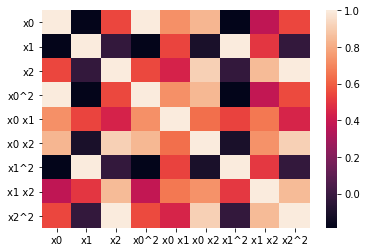

In [45]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [46]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
x0,1.000000,-0.178532,0.542065,0.999710,0.731002,0.836154,-0.186701,0.373188,0.544065
x1,-0.178532,1.000000,-0.027592,-0.178767,0.540347,-0.104801,0.999473,0.502189,-0.027187
x2,0.542065,-0.027592,1.000000,0.549161,0.443159,0.914041,-0.025158,0.850422,0.999881
x0^2,0.999710,-0.178767,0.549161,1.000000,0.730759,0.840733,-0.186603,0.379204,0.551201
x0 x1,0.731002,0.540347,0.443159,0.730759,1.000000,0.641393,0.533193,0.666114,0.445166
x0 x2,0.836154,-0.104801,0.914041,0.840733,0.641393,1.000000,-0.107150,0.734587,0.914968
x1^2,-0.186701,0.999473,-0.025158,-0.186603,0.533193,-0.107150,1.000000,0.504145,-0.024750
x1 x2,0.373188,0.502189,0.850422,0.379204,0.666114,0.734587,0.504145,1.000000,0.850543
x2^2,0.544065,-0.027187,0.999881,0.551201,0.445166,0.914968,-0.024750,0.850543,1.000000


In [ ]:
# interaction_only = True

In [48]:
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

X_poly = poly.fit_transform(X)
print(X_poly.shape)

pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()  
# x0^2, x1^2, and x2^2 went away as they use repeat variables

(162501, 6)


,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


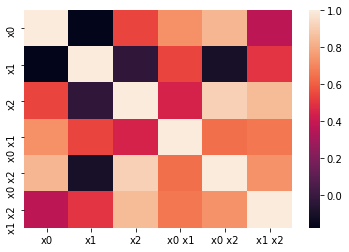

In [49]:
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [50]:
# Removes from biases from the correlation matrix
pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
x0,1.000000,-0.178532,0.542065,0.731002,0.836154,0.373188
x1,-0.178532,1.000000,-0.027592,0.540347,-0.104801,0.502189
x2,0.542065,-0.027592,1.000000,0.443159,0.914041,0.850422
x0 x1,0.731002,0.540347,0.443159,1.000000,0.641393,0.666114
x0 x2,0.836154,-0.104801,0.914041,0.641393,1.000000,0.734587
x1 x2,0.373188,0.502189,0.850422,0.666114,0.734587,1.000000
